# Baseball Changepoints

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from os import getenv
from tqdm import tqdm

from math import comb
from scipy.stats import chi2

In [257]:
def compute_binomial_LLR(hab):
    """
    Compute LLR comparing two hypotheses: the batting
    average/p is the same on the LHS/RHS and p is different
    on the LHS/RHS.

    We drop the combinatorics because they are common across
    the two hypotheses: e.g., the LHS has a factor of log(BAL C HL)
    and the RHS has a factor of log(BAR C HR)
    """
    def _llr_no_combinatorics(hab):
        eps = 1E-6
        h, ab = hab.sum(axis=0)
        p = np.clip(h / ab, eps, 1 - eps)
        return h * np.log(p) + (ab - h) * np.log(1-p)
    
    h, ab = hab.sum(axis=0)
    bavg = h / ab
    logL = _llr_no_combinatorics(hab)

    # Compute the most likely changepoint
    cum_abs = np.cumsum(hab[:,1])
    cum_h = np.cumsum(hab[:,0])
    cumdiff = cum_h - bavg * cum_abs

    for cp in [cumdiff.argmax(), cumdiff.argmin()]:
        if cp == 0 or cp == len(cumdiff):
            continue
        logLL = _llr_no_combinatorics(hab[:cp])
        logLR = _llr_no_combinatorics(hab[cp:])
        LLR = 2 * (logLL + logLR - logL)
        p = 1 - chi2.cdf(LLR, 1) # probability of observing this LLR or higher
        # 1 ddof because LR model has 2 params, single model has 1
        return p

In [5]:
data_dir = Path(getenv("HOME"), "data", "mlb-2023")

In [224]:
COLS = [
    "player_id", "player_name", "game_date", "abs", "hits"
]
df = pd.concat(
    [pd.read_csv(f)[COLS] for f in data_dir.glob("2023-*.csv")]
).reset_index(drop=True).rename(columns=dict(abs="atbats")).dropna()
df.game_date = pd.to_datetime(df.game_date)
df = df.sort_values("game_date").reset_index(drop=True)

In [225]:
players = df.groupby("player_id").atbats.sum().sort_values(ascending=False)
players = players[players > 100]
len(players)

449

In [226]:
sample_player_id = players.sample(n=1).index.values[0]
player_df = df.query(f"player_id == {sample_player_id}")
sample_player_id, len(player_df)

(641857, 148)

In [227]:
bavg = player_df.hits.sum() / player_df.atbats.sum()
print(f"{bavg:.3f}")

0.240


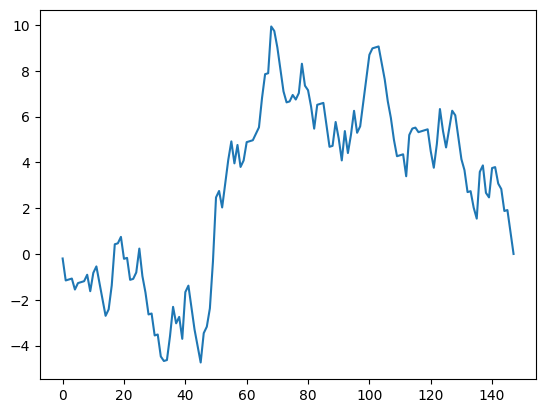

In [228]:
cusum = (player_df.hits - player_df.atbats * bavg).cumsum()
plt.plot(cusum.values)
plt.show()

In [256]:
ps = []
for _pid, player_df in df.groupby("player_id"):
    if len(player_df) < 50:
        continue
    v = player_df[["hits", "atbats"]].astype("int").values
    ps.append(compute_binomial_LLR(v))
ps = np.array(ps)
ps.sort()

66 0.016356182277434073
97 2.475563398842155
41 1.495923143171467
72 0.19416901183552682
35 0.49070730802662865
114 0.4167549700383688
69 1.8793769016928081
117 2.225766263489163
15 0.5752147035055089
100 0.09953272988070694
28 0.571130907200768
45 0.24925445020636516
30 3.278030314691023
92 2.0998511997402147
49 0.8438472853806047
58 1.3605262893760255
41 0.05225801837383415
40 2.1554895576653053
53 0.3770762931636682
77 0.2086898121499985
76 1.735708321251252
47 5.132103979133262
43 0.8115364759082979
113 1.2336767743393011
37 3.712858601476114
110 0.7743170781009212
37 1.0438658406386594
79 3.028900433180638
52 8.532026813783887
14 2.561873611221472
36 1.5724764585496587
82 1.7548206125023853
33 1.2440390390694347
19 4.201575832050651
143 2.0180557047201546
78 0.03403712667898162
44 1.9145748402949607
2 6.9356369881391515
71 0.35933922651247485
102 0.23730823763526132
82 0.9117660165476877
31 0.018827054305688762
49 1.765555051840181
58 1.3403440202996535
88 0.882201751521734
10 3.5

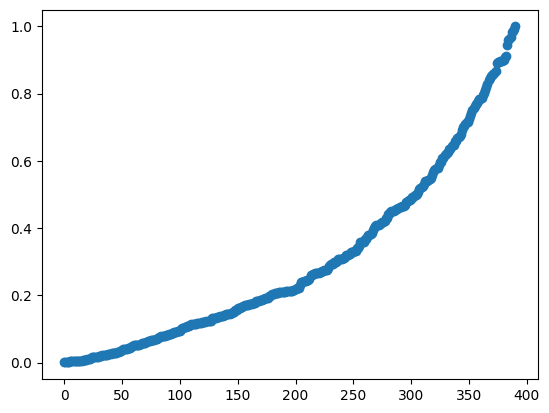

In [253]:
plt.scatter(np.arange(len(ps)), ps)

In [244]:
0.2 / len(ps)

0.0005115089514066497